In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, colors, cm
from four_level_transmons.plotting import plotComplexMatrixHinton, plotSignalAndSpectrum
import scipy.signal as scps

2022-07-05 18:42:58.513885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-05 18:42:58.513912: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# levels of the model
level_labels_transmon = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle"]
for i in range(len(level_labels_transmon), 4):
    level_labels_transmon.append("leakage")
level_labels = []
level_labels_with_leakage = []
level_labels_short = []
for i in range(4):
    for j in range(4):
        if i > 3 or j > 3:
            level_labels_with_leakage.append("leakage")
            level_labels_short.append(None)
        else:
            s = f"${level_labels_transmon[i]},{level_labels_transmon[j]}$"
            level_labels.append(s)
            level_labels_with_leakage.append(s)
            level_labels_short.append(f"{i},{j}")

stateEnergies = [
    (-42106.231698993695, '0,0'),
    (4499114771.5089655, '0,1'),
    (5000711781.167839, '1,0'),
    (8748800295.696821, '0,2'),
    (9496990718.064747, '1,1'),
    (9703804156.096302, '2,0'),
    (12748799935.48425, '0,3'),
    (13747449747.302649, '1,2'),
    (14089562795.824818, '3,0'),
    (14213807653.516392, '2,1'),
    (17746706110.335068, '1,3'),
    (18438398982.764374, '2,2'),
    (18614913260.709934, '3,1'),
    (22441469946.98455, '2,3'),
    (22859083368.21059, '3,2'),
    (26850428582.564625, '3,3')
]

# all energy transitions
items = sorted(stateEnergies, key=lambda x: x[0])
transitions = []
for i in range(len(items)):
    for j in range(len(items)):
        if i != j:
            #print(i, j)
            E = items[j][0] - items[i][0]
            if E > 0:
                transitions.append((E, items[i][1] + " - " + items[j][1]))

In [3]:
time, signal = np.load('/home/user/Schreibtisch/sinus basis partial spectrum/10 freqs/1000ns/CZ/signal_t2_after.npy')

leftcut:  [  14   15   16 ... 1093 1094 1095]
leftidx:  14
rightcut:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123]


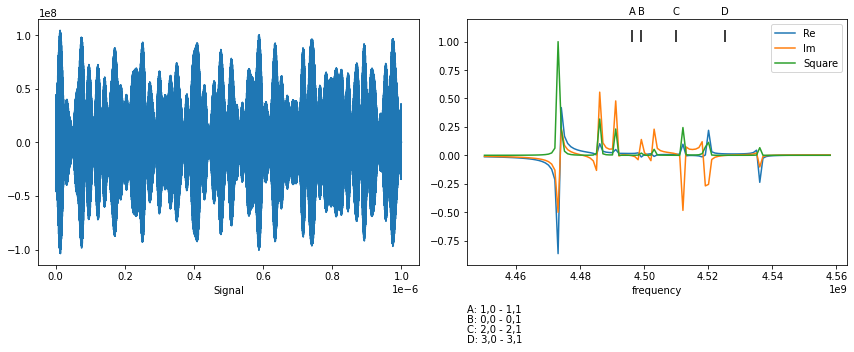

In [7]:
plotSignalAndSpectrum(time, real=signal, filename=None, spectralThreshold=1e-4, states=transitions, spectralCutoff=(4.45e9, 4.56e9))

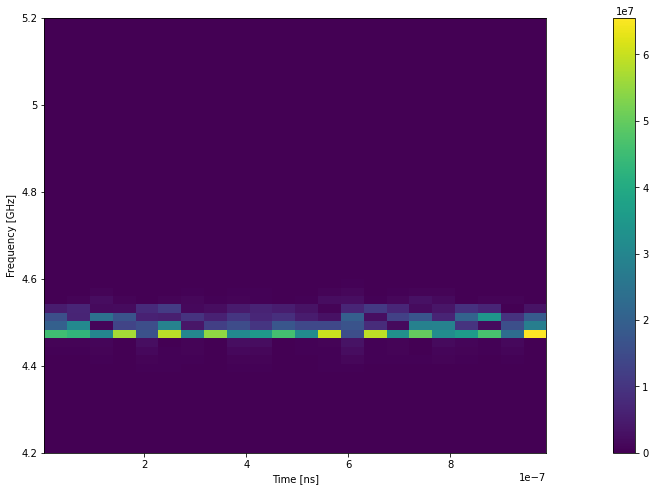

In [81]:
f, t, Sxx = scps.spectrogram(signal, fs=20e9, nperseg=1024)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plt.pcolormesh(t, f, Sxx, shading='nearest', cmap=cm.get_cmap("viridis"))

ticks = mpl.ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y*1e-9))
ax.yaxis.set_major_formatter(ticks)
ax.set_ylim(4.2e9, 5.2e9)
plt.ylabel('Frequency [GHz]')
plt.xlabel('Time [ns]')

norm = colors.Normalize(vmin=np.min(Sxx), vmax=np.max(Sxx))
cbar = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cm.get_cmap("viridis")),
    ax=ax,
    shrink=1,
    pad=0.1,
    #ticks=[-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
)
plt.show()

In [ ]:
def fidelity(A, B):
    return np.abs(np.trace(A @ np.conjugate(B.T)) / A.shape[0])**2

In [ ]:
Udrift = np.load('/home/user/Schreibtisch/single frequencies/empty/propagator_before.npy')
plotComplexMatrixHinton(Udrift, maxAbsolute=1, xlabels=level_labels, ylabels=level_labels, gridColour="gray",
                            filename=None, colourMap='hsv')

In [ ]:
U_f = [None] * 10
Udrive_f = [None] * 10
for i in range(10):
    U_f[i] = np.load(f'/home/user/Schreibtisch/single frequencies/CZ t1/f{i}/propagator_before.npy')
    Udrive_f[i] = U_f[i] @ np.conjugate(Udrift.T)
    #plotComplexMatrixHinton(U_f[i], maxAbsolute=1, xlabels=level_labels, ylabels=level_labels, gridColour="gray",
    #                        filename=f'/home/user/Schreibtisch/CZ single frequencies/t1/propagators/drift+drive_{i}.svg', colourMap='hsv')

In [ ]:
fidelities = []
for i in range(10):
    for j in range(i, 10):
        for k in range(j, 10):
            for l in range(k, 10):
                U = Udrive_f[i] @ Udrive_f[j] @ Udrive_f[k] @ Udrive_f[l]
                fidelities.append((i, j, k, l, fidelity(U, np.eye(16))))

fidelities.sort(key=lambda x: x[4])
for x in list(reversed(fidelities)):
    print(x[4], x[0], x[1], x[2], x[3])

In [ ]:
A = np.eye(16)
for U in Udrive_f:
    A = A @ U
plotComplexMatrixHinton(A, maxAbsolute=1, xlabels=level_labels, ylabels=level_labels, gridColour="gray",
                        filename=None, colourMap='hsv')